In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mauritanian-license-plate-recognition-challenge-24:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F75388%2F9385374%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240901%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240901T155022Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f2ec64b214d0c0ce132c3cdeb045e06d82d8d142175ccc6d07a781b1bfbc07d897aa7efac28bfd3dc09e7322b273159b0f15f3edb0562b3c7f8be9d5de2c4295264c1afe730ca68dfe54bab7ec44654359ad7b153a437d2468b253b9e581a387965e8145aff7723593a2bc1895a7da07688508209ef080d84813f95ab7422b2879cda33f703daefcd17ff6ffc1055ad127b235db9d37bb4bfa9be66ffa565896394e7e6b31d8964b2f3c92d680c511cfa45bab4db022ad1ce6ed9f90939a2c3d9554982c0823964cffb90534099f047b33dca32dc7688ea731f622509f9c8b5d320f2336ad5c25b835e3424c4549ee9122fa1a203a4a482a37e9841747f9aad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 197710198 bytes downloaded

Downloaded and uncompressed: mauritanian-license-plate-recognition-challenge-24

Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/train_labels.csv

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/submission_template.csv

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_195.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_290.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_369.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_101.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_28.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_104.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_141.jpg

/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/img_92.jpg

/kagg

# Mauritanian Number-Plate Recognition Challenge

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_labels  = pd.read_csv('/kaggle/input/mauritanian-license-plate-recognition-challenge-24/train_labels.csv')

In [5]:
print(train_labels .head())
print(train_labels.info())

    img_id plate_number

0    img_1     8630AB06

1   img_10     5115AM00

2  img_100     7812AA02

3  img_102     6421AA03

4  img_103     0099AC08

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 204 entries, 0 to 203

Data columns (total 2 columns):

 #   Column        Non-Null Count  Dtype 

---  ------        --------------  ----- 

 0   img_id        204 non-null    object

 1   plate_number  204 non-null    object

dtypes: object(2)

memory usage: 3.3+ KB

None


# Data Exploration and Preparation:

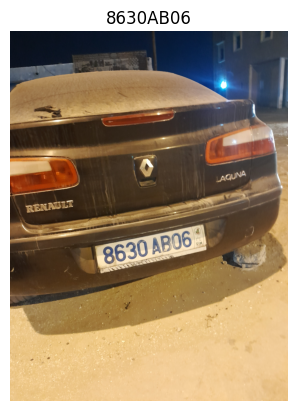

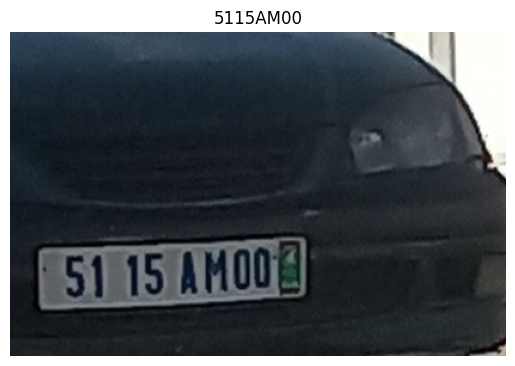

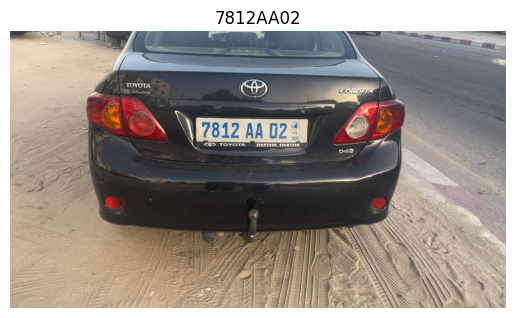

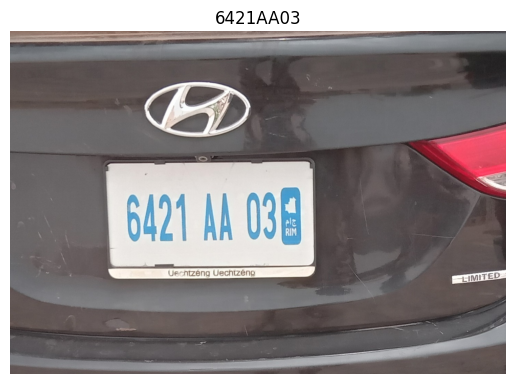

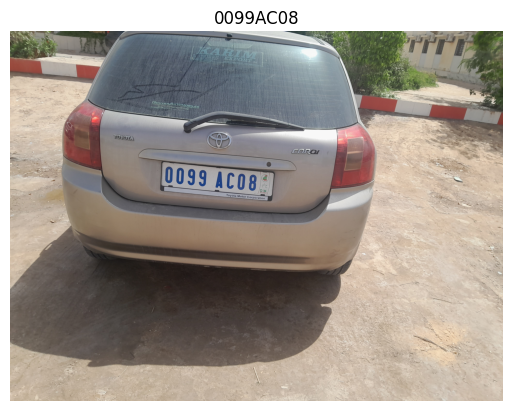

In [6]:
import matplotlib.pyplot as plt
import cv2

# Function to display an image
def display_image(img_path, title):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first 5 images with their corresponding license plate numbers
for index, row in train_labels.head(5).iterrows():
    img_path = f'/kaggle/input/mauritanian-license-plate-recognition-challenge-24/train_data/final_train_set/{row["img_id"]}.jpg'
    display_image(img_path, row['plate_number'])


In [7]:
character_counts = train_labels['plate_number'].str.replace(" ", "").apply(list).explode().value_counts()

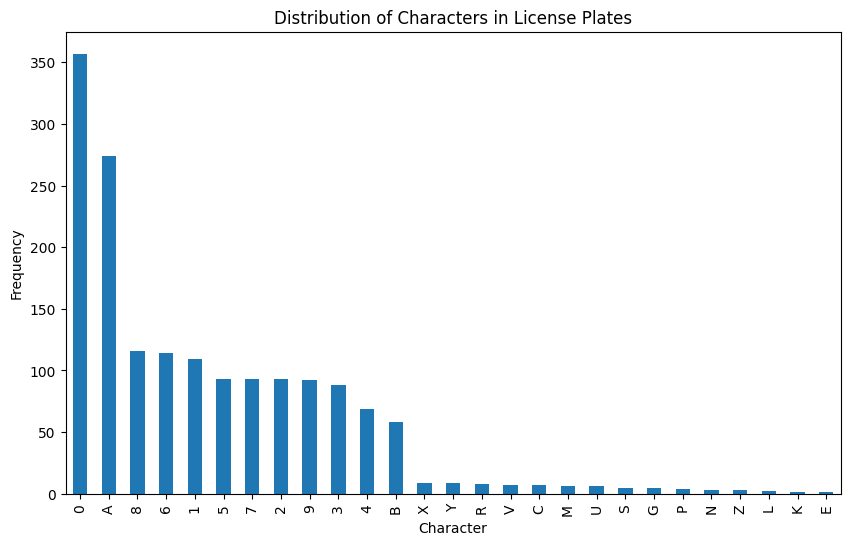

In [8]:
character_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Characters in License Plates')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()

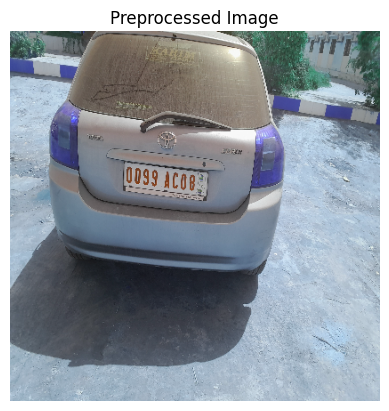

In [9]:
import numpy as np

def preprocess_image(img_path, target_size=(416, 416)):
    # Load the image
    img = cv2.imread(img_path)

    # Resize the image
    img_resized = cv2.resize(img, target_size)

    # Normalize the image (scale pixel values to [0, 1])
    img_normalized = img_resized / 255.0

    return img_normalized

# Preprocess the first image as an example
img_path = f'/kaggle/input/mauritanian-license-plate-recognition-challenge-24/train_data/final_train_set/{row["img_id"]}.jpg'
preprocessed_img = preprocess_image(img_path)

# Display the preprocessed image
plt.imshow(preprocessed_img)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


In [10]:
# Preprocess all images in the dataset
preprocessed_images = []

for img_id in train_labels['img_id']:
    img_path = f'/kaggle/input/mauritanian-license-plate-recognition-challenge-24/train_data/final_train_set/{row["img_id"]}.jpg'
    preprocessed_img = preprocess_image(img_path)
    preprocessed_images.append(preprocessed_img)

# Convert the list of preprocessed images to a NumPy array
preprocessed_images = np.array(preprocessed_images)

# Check the shape of the preprocessed images array
print(preprocessed_images.shape)


(204, 416, 416, 3)


In [11]:
# Create a character-to-integer mapping
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_to_num = {char: i for i, char in enumerate(characters)}

# Encode the plate numbers
def encode_plate(plate):
    return [char_to_num[char] for char in plate]

# Apply the encoding to all plate numbers
encoded_labels = train_labels['plate_number'].apply(encode_plate)

# Convert the encoded labels to a NumPy array
encoded_labels = np.array(encoded_labels)

# Check the shape and the first few encoded labels
print(encoded_labels.shape)
print(encoded_labels[:5])


(204,)

[list([8, 6, 3, 0, 10, 11, 0, 6]) list([5, 1, 1, 5, 10, 22, 0, 0])

 list([7, 8, 1, 2, 10, 10, 0, 2]) list([6, 4, 2, 1, 10, 10, 0, 3])

 list([0, 0, 9, 9, 10, 12, 0, 8])]


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum length of the license plate numbers
max_length = max([len(label) for label in encoded_labels])

# Pad the encoded labels
padded_labels = pad_sequences(encoded_labels, maxlen=max_length, padding='post')

# Check the shape and the first few padded labels
print(padded_labels.shape)
print(padded_labels[:5])

(204, 8)

[[ 8  6  3  0 10 11  0  6]

 [ 5  1  1  5 10 22  0  0]

 [ 7  8  1  2 10 10  0  2]

 [ 6  4  2  1 10 10  0  3]

 [ 0  0  9  9 10 12  0  8]]


In [13]:
import tensorflow as tf

# Define the number of unique characters (as previously calculated)
num_classes = len(char_to_num)  # This should be 23

# Convert the padded labels to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(padded_labels, num_classes=num_classes)

# Check the shape and the first few one-hot encoded labels
print(one_hot_labels.shape)
print(one_hot_labels[0])


(204, 8, 36)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, one_hot_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

Training data shape: (163, 416, 416, 3), Training labels shape: (163, 8, 36)

Validation data shape: (41, 416, 416, 3), Validation labels shape: (41, 8, 36)


# Model Development:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Reshape

model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(416, 416, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Replace the final Dense layer with this:
model.add(Dense(8 * 36, activation='softmax'))  # 8 characters, each with 36 possible classes
model.add(Reshape((8, 36)))  # Reshape to (8, 36)


# Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.

  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 416, 416, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 416, 416, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 416, 416, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 208, 208, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 208, 208, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 208, 208, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 208, 208, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 104, 104, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 104, 104, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 104, 104, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 104, 104, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 52, 52, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 52, 52, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 52, 52, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 26, 26, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 346112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     354,419,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 356,653,216 (1.33 GB)

 Trainable params: 356,648,224 (1.33 GB)

 Non-trainable params: 4,992 (19.50 KB)

# Training and Evaluation:

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=3,          # Wait for 3 epochs with no improvement
    min_lr=1e-6          # Set a minimum learning rate
)


In [31]:

# Train the model with the learning rate scheduler
history = model.fit(
    X_train,
    y_train,
    epochs=200,  # Increase epochs since the learning rate will decrease over time
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler]  # Add the scheduler to callbacks
)

Epoch 1/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.3449 - loss: 1.9606 - val_accuracy: 0.3811 - val_loss: 1.7390 - learning_rate: 1.0000e-06

Epoch 2/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.3645 - loss: 1.9438 - val_accuracy: 0.3811 - val_loss: 1.7395 - learning_rate: 1.0000e-06

Epoch 3/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.3591 - loss: 1.9871 - val_accuracy: 0.3811 - val_loss: 1.7396 - learning_rate: 1.0000e-06

Epoch 4/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.3631 - loss: 1.9202 - val_accuracy: 0.3811 - val_loss: 1.7399 - learning_rate: 1.0000e-06

Epoch 5/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.3616 - loss: 1.9389 - val_accuracy: 0.3811 - val_loss: 1.7393 - learning_rate: 1.0000e-06

Epoch 6/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.3775 - loss: 1.9216 - val_accuracy: 0.3811 - val_loss: 1.7391 - learning_rate: 1.0000e-06

Epoch 7/200

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 326

# Submission Preparation:

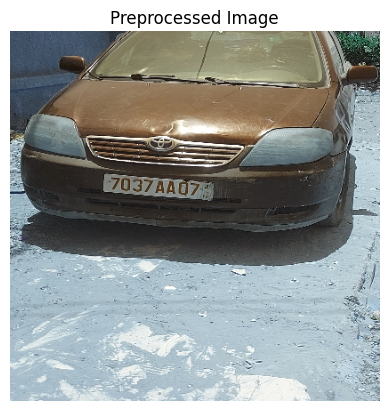

In [32]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Directory path to the test images
img_dir_test = '/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/'

# Preprocess all images in the dataset
preprocessed_images_test = []

def preprocess_image(img_path, target_size=(416, 416)):
    # Load the image
    img = cv2.imread(img_path)

    # Resize the image
    img_resized = cv2.resize(img, target_size)

    # Normalize the image (scale pixel values to [0, 1])
    img_normalized = img_resized / 255.0

    return img_normalized

# Loop over all images in the directory
for image_name in os.listdir(img_dir_test):
    # Construct the full path to the image
    image_path = os.path.join(img_dir_test, image_name)

    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)

    # Append the preprocessed image to the list
    preprocessed_images_test.append(preprocessed_img)

# Convert the list to a numpy array for model input
preprocessed_images_test = np.array(preprocessed_images_test)

# Display the first preprocessed image as an example
plt.imshow(preprocessed_images_test[0])
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


In [33]:
# Assuming you have already preprocessed the images as done before
X_test = np.array(preprocessed_images_test)

# X_test is now ready to be fed into the model for predictions
print(f"Shape of X_test: {X_test.shape}")


Shape of X_test: (100, 416, 416, 3)


In [35]:
# Make predictions on the test data
predictions = model.predict(X_test)
# Decode predictions
decoded_predictions = []

# Assuming 'char_list' is a list of possible characters (e.g., digits and letters)
for pred in predictions:
    plate = ''.join([characters[np.argmax(p)] for p in pred])
    decoded_predictions.append(plate)
import pandas as pd




4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


In [36]:
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
char_list = list(characters)
# Define the directory containing the test images
img_dir_test = '/kaggle/input/mauritanian-license-plate-recognition-challenge-24/test_data/final_test_set/'

# Get a list of all file paths in the test directory
test_image_paths = [os.path.join(img_dir_test, filename) for filename in os.listdir(img_dir_test) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Extract the image IDs by removing the file extensions
test_image_ids = [os.path.splitext(os.path.basename(image_path))[0] for image_path in test_image_paths]
print(f"Number of test image IDs: {len(test_image_ids)}")
decoded_predictions = decoded_predictions
print(f"Number of decoded predictions: {len(decoded_predictions)}")

Number of test image IDs: 100

Number of decoded predictions: 100


In [39]:
import numpy as np
import pandas as pd

# Assuming `decoded_predictions` is your list of predicted license plates
# and `test_image_ids` contains the corresponding image IDs
charac = ["X0","X1","X2","X3","X4","X5","X6","X7","X8","X9","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
# Initialize a DataFrame for the submission
submission = pd.DataFrame(columns=['id'] + charac)

# Loop through each prediction and corresponding image ID
rows = []
for img_id, plate in zip(test_image_ids, decoded_predictions):
    for pos, char in enumerate(plate):
        row = [0] * len(characters)  # Initialize a row with all zeros
        if char in characters:
            index = characters.index(char)
            row[index] = 1
        # Create a unique ID for each character's position
        row_id = f"{img_id}_{pos+1}"
        # Create a Series with the row_id and the one-hot encoded row
        row_series = pd.Series([row_id] + row, index=submission.columns)
        rows.append(row_series)

# Concatenate all rows into the DataFrame
submission = pd.concat([submission, pd.DataFrame(rows)], ignore_index=True)

# Save the submission file
submission.to_csv('submission4.csv', index=False)

print("Submission file created successfully.")


Submission file created successfully.
